In [ ]:
import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()

In [ ]:
# # Dataset Split Code (Run Once and Comment Out)

# import os
# import numpy as np
# from tqdm import tqdm
# from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from sklearn.model_selection import train_test_split

# # Directories
# color_dir = '/home/nandhitha/Image_Colourization/landscape_images/landscape Images/color'
# gray_dir = '/home/nandhitha/Image_Colourization/landscape_images/landscape Images/gray'
# train_dir = './dataset/train'
# test_dir = './dataset/test'
# IMG_SIZE = 128

# # Function to sort alphanumeric filenames
# def sorted_alphanumeric(data):
#     import re
#     convert = lambda text: int(text) if text.isdigit() else text.lower()
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
#     return sorted(data, key=alphanum_key)

# # Load images from folder
# def load_images_from_folder(folder):
#     images = []
#     files = sorted_alphanumeric(os.listdir(folder))
#     for filename in tqdm(files):
#         img_path = os.path.join(folder, filename)
#         try:
#             img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#             img = img_to_array(img) / 255.0
#             images.append(img)
#         except Exception as e:
#             print(f"Error loading image {img_path}: {e}")
#     return np.array(images)

# # One-time Dataset Split (90% Train, 10% Test)
# def split_and_store_dataset():
#     if not os.path.exists(train_dir) or not os.path.exists(test_dir):
#         print("Splitting dataset...")
#         os.makedirs(train_dir, exist_ok=True)
#         os.makedirs(test_dir, exist_ok=True)
        
#         color_images = load_images_from_folder(color_dir)
#         gray_images = load_images_from_folder(gray_dir)
        
#         X_train, X_test, y_train, y_test = train_test_split(
#             gray_images, color_images, test_size=0.1, random_state=42)
        
#         np.save(os.path.join(train_dir, 'X_train.npy'), X_train)
#         np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
#         np.save(os.path.join(test_dir, 'X_test.npy'), X_test)
#         np.save(os.path.join(test_dir, 'y_test.npy'), y_test)
        
#         print("Dataset split and stored successfully.")
#     else:
#         print("Dataset already split. Skipping...")

# # Call this function ONCE and then comment it out
# split_and_store_dataset()


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

2025-02-23 11:19:38.028045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 11:19:38.036705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740309578.047372   15789 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740309578.050939   15789 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 11:19:38.062404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# GPU Settings for RTX 4060 Optimization
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable Mixed Precision for Tensor Core Utilization
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) for faster execution
tf.config.optimizer.set_jit(True)

# Check GPU Availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Directories
train_dir = './dataset/train'
test_dir = './dataset/test'
IMG_SIZE = 128

In [4]:
# Load Train and Test Data
def load_dataset():
    X_train = np.load(os.path.join(train_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    X_test = np.load(os.path.join(test_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    return X_train, y_train, X_test, y_test

In [5]:
# Load the data
X_train, y_train, X_test, y_test = load_dataset()
print("Dataset loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Dataset loaded successfully.
X_train shape: (6416, 128, 128, 3)
y_train shape: (6416, 128, 128, 3)
X_test shape: (713, 128, 128, 3)
y_test shape: (713, 128, 128, 3)


In [6]:
def build_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.UpSampling2D((2, 2))(c5)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.UpSampling2D((2, 2))(c6)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid', dtype='float32')(c7)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

model = build_unet_model((IMG_SIZE, IMG_SIZE, 3))
model.summary()

I0000 00:00:1740309588.151026   15789 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,008,899 (26.74 MB)

 Trainable params: 7,008,899 (26.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['accuracy'])


In [8]:
history = model.fit(
    X_train, y_train, 
    batch_size=64,
    epochs=50, 
    validation_data=(X_test, y_test),
)

Epoch 1/50


I0000 00:00:1740309592.865511   15950 service.cc:148] XLA service 0x7fec44016f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740309592.865560   15950 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1740309592.870162   15950 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1740309592.907856   15950 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-23 11:19:53.833426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-23 11:20:03.100350: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,128,128,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,128,128,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_la

100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2840 - loss: 0.0716

2025-02-23 11:21:57.042884: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,128,128,64]{3,2,1,0}, f16[64,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-23 11:21:57.076765: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.035905413s
Trying algorithm eng0{} for conv (f16[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,128,128,64]{3,2,1,0}, f16[64,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"a

101/101 ━━━━━━━━━━━━━━━━━━━━ 154s 505ms/step - accuracy: 0.2849 - loss: 0.0712 - val_accuracy: 0.3842 - val_loss: 0.0263
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.3923 - loss: 0.0246 - val_accuracy: 0.3737 - val_loss: 0.0245
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.4052 - loss: 0.0219 - val_accuracy: 0.4385 - val_loss: 0.0195
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.4563 - loss: 0.0199 - val_accuracy: 0.4523 - val_loss: 0.0203
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.4606 - loss: 0.0187 - val_accuracy: 0.5087 - val_loss: 0.0179
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.4854 - loss: 0.0176 - val_accuracy: 0.5035 - val_loss: 0.0169
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.4704 - loss: 0.0174 - val_accuracy: 0.4377 - val_loss: 0.0165
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.4784 - loss: 0.0167 - va

In [9]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5701 - loss: 0.0127
Test Accuracy: 56.87%


In [10]:
# Save Model in Keras Format
model.save('colorization_model.keras')
print("Model saved in Keras format as colorization_model.keras")


Model saved in Keras format as colorization_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


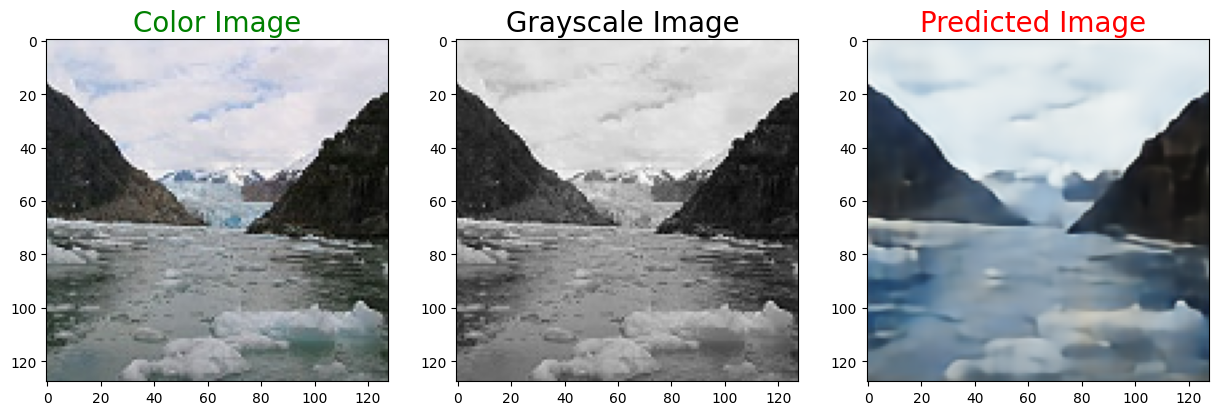

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


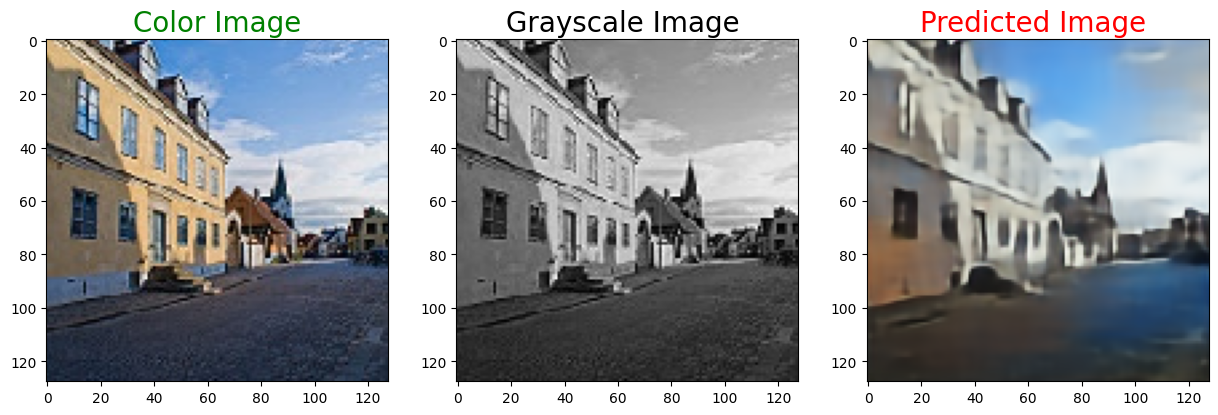

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


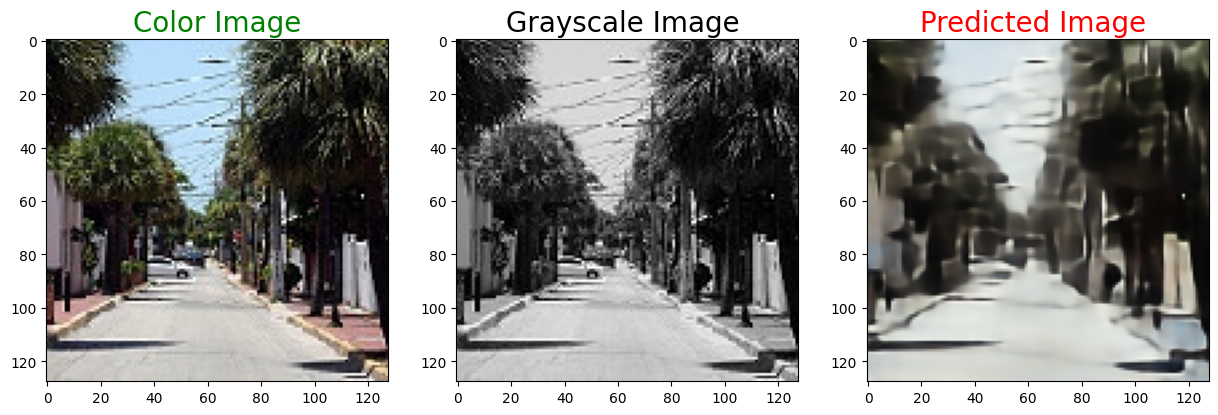

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


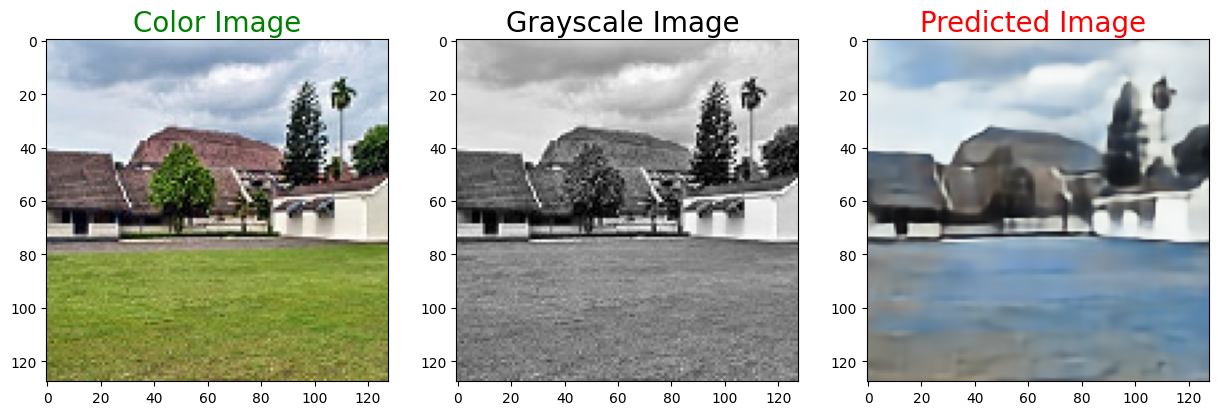

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


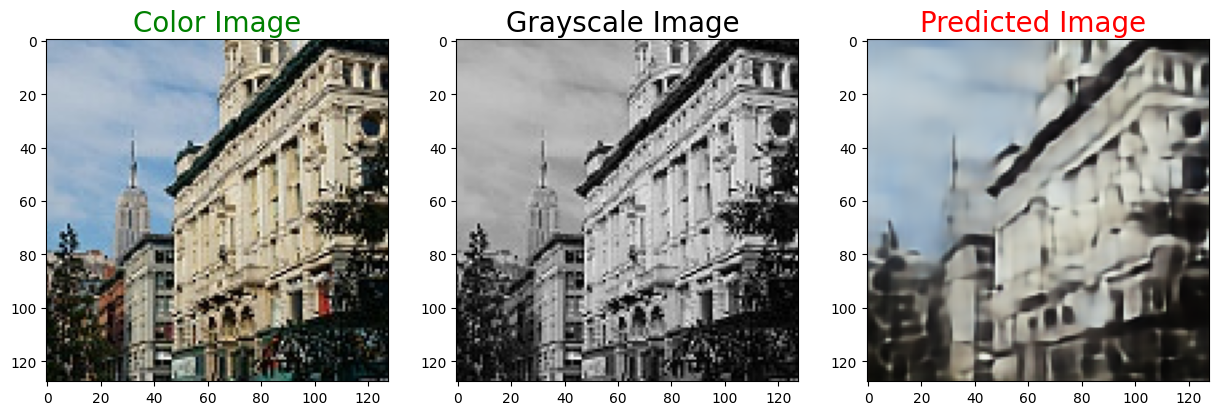

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


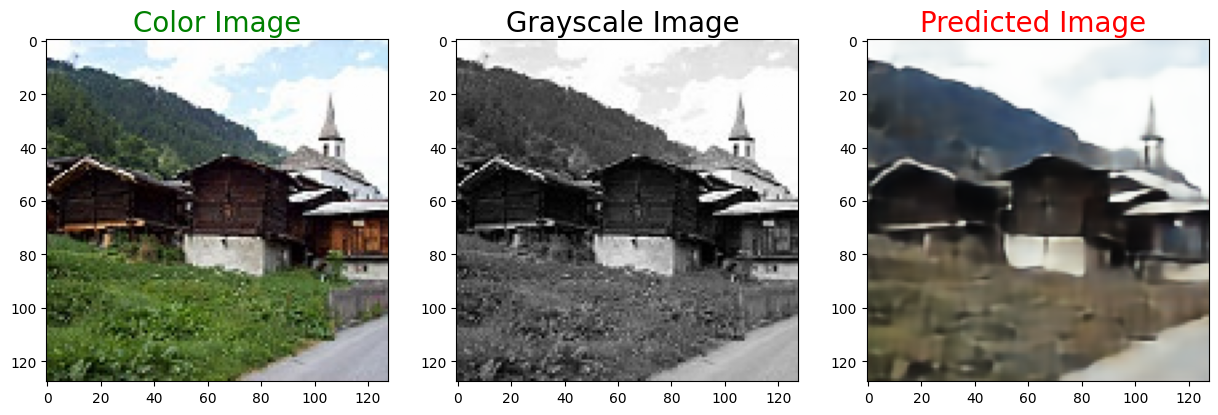

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


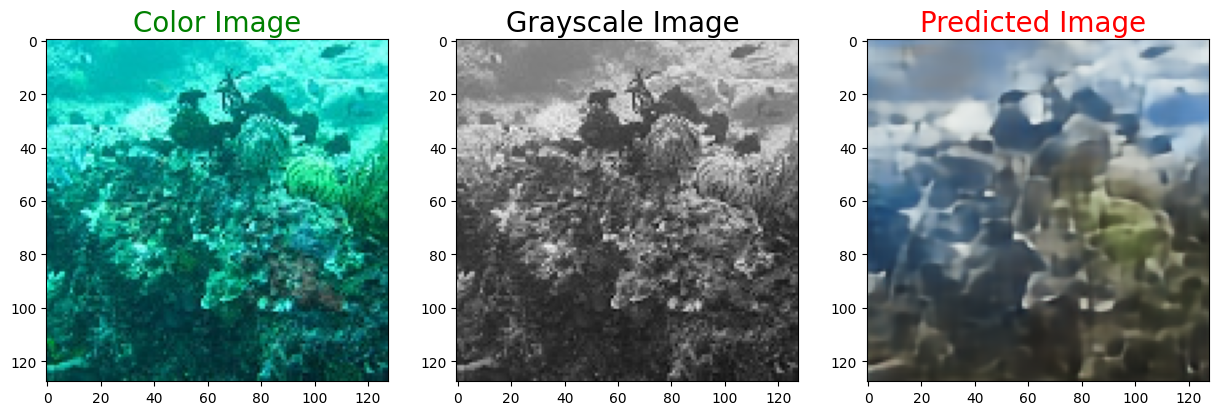

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


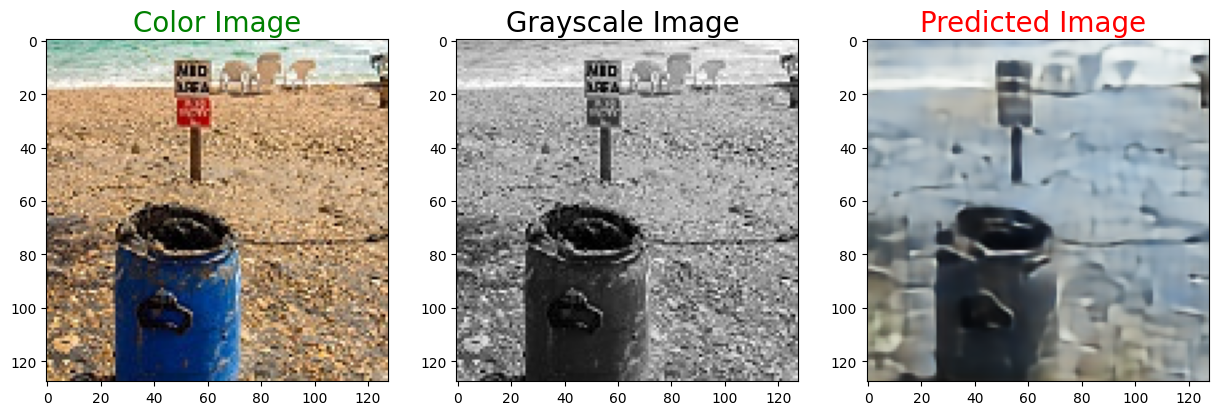

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


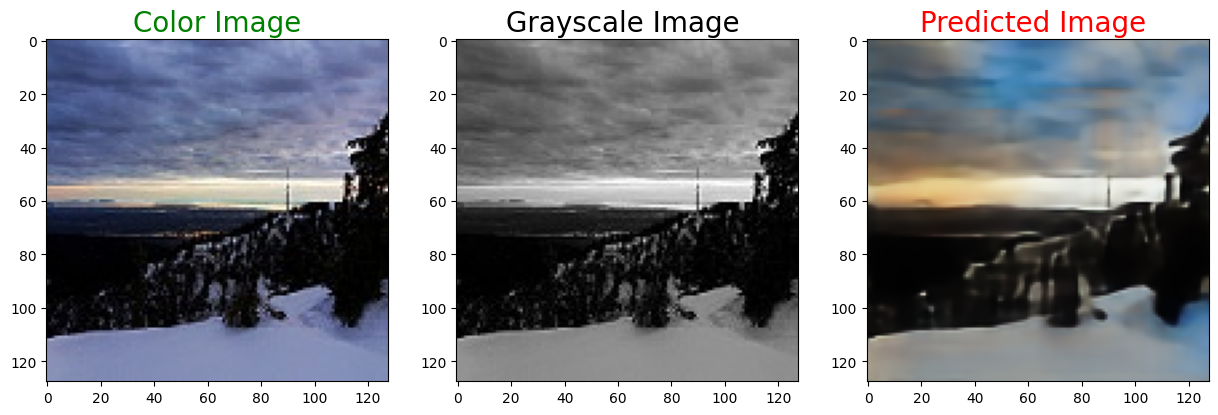

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


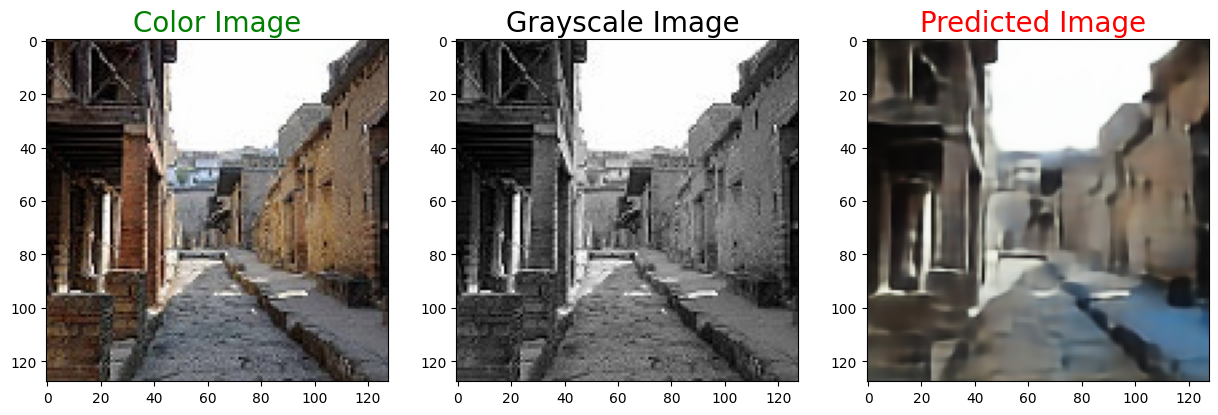

In [15]:
import matplotlib.pyplot as plt

def plot_images(color, grayscale, predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(170, 180):
    predicted = np.clip(model.predict(X_test[i].reshape(1, IMG_SIZE, IMG_SIZE,3)),0.0,1.0).reshape(IMG_SIZE, IMG_SIZE,3)
    plot_images(y_test[i], X_test[i], predicted)